## Recommendation with Embeddings and Multi-layer Perceptrons

This is a Pytroch implementation of a recommendation model introduced in [Deep Neural Networks for YouTube Recommendations](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45530.pdf) using [MovieLens 100k](https://grouplens.org/datasets/movielens/100k/) (`ml-100k`).

## Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = 'data/ml-100k/'

## Data Processing

There are 5 dataset pairs for training and validation of `ml-100k` dataset. We normalize the user and item index to start from 0 to comply with Python's style. The training set consists of 80,000 user-item-rating tuples and the validation set consists of 20,000 such tuples.

In [2]:
val_idx = 1 #which dataset pair to use
nb_users = 943 #total number of users
nb_items = 1682 #total number of items

In [3]:
train_df = pd.read_csv(f'{data_path}u{val_idx}.base',sep='\t',header=None)
train_df.columns = ['user_id','item_id','rating','ts']
train_df['user_id'] = train_df['user_id'] -1 #start index at 0
train_df['item_id'] = train_df['item_id'] -1
valid_df = pd.read_csv(f'{data_path}u{val_idx}.test',sep='\t',header=None)
valid_df.columns = ['user_id','item_id','rating','ts']
valid_df['user_id'] = valid_df['user_id'] -1 #start index at 0
valid_df['item_id'] = valid_df['item_id'] -1
train_df.shape, valid_df.shape

((80000, 4), (20000, 4))

We found that all users are in the training set so we should have no out-of-sample problem with the user embeddings.

In [4]:
#check number of unique users in both training and test set
train_users = train_df.user_id.unique()
valid_users = valid_df.user_id.unique()
len(train_users),len(valid_users)

(943, 459)

In [5]:
i = 0
for u in valid_users:
    if u in train_users: i+=1
i

459

However, we found that out of 1,410 items in the validation set only 1,378 items exist in the training set. This will affect when we predict ratings of those unseen items in the validation set.

In [6]:
train_items = train_df.item_id.unique()
valid_items = valid_df.item_id.unique()
len(train_items),len(valid_items)

(1650, 1410)

In [7]:
i = 0
for u in valid_items:
    if u in train_items: i+=1
i

1378

## Dataset

We create a Pytorch dataset object that returns the tuple of `(user,item,rating)` tensors based on the dataframe we read in. From those datasets, we can load data in batch by converting them to Pytorch dataloader objects. Here we set the batch size to 2000.

In [8]:
class CollabRatingDataset(Dataset):
    def __init__(self, df, user_col=0, item_col=1, rating_col=2):
        self.df = df
        self.user_tensor = torch.tensor(self.df.iloc[:,user_col], dtype=torch.long, device = device)
        self.item_tensor = torch.tensor(self.df.iloc[:,item_col], dtype=torch.long, device = device)
        self.target_tensor = torch.tensor(self.df.iloc[:,rating_col], dtype=torch.float32, device = device)
        
    def __getitem__(self, index):
        return(self.user_tensor[index], self.item_tensor[index], self.target_tensor[index])

    def __len__(self):
        return(self.user_tensor.shape[0])

In [9]:
bs = 2000
train_ds = CollabRatingDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_ds = CollabRatingDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=4)

In [10]:
len(train_ds),len(valid_ds),len(train_dl),len(valid_dl)

(80000, 20000, 40, 10)

In [11]:
train_ds[:3]

(tensor([0, 0, 0]), tensor([0, 1, 2]), tensor([5., 3., 4.]))

In [12]:
next(iter(train_dl))

[tensor([ 93, 373, 789,  ..., 898, 233, 730]),
 tensor([  89,  824,   82,  ...,  171, 1100, 1086]),
 tensor([3., 3., 3.,  ..., 4., 3., 1.])]

## Architecture

Our architecture consists of two parts:
1. **Embedding Layers** to convert user and item indice to embedding vectors
2. **Fully-connected Layers** to take input of concatenated embedding vectors and output the rating

In [13]:
class CollabNet(nn.Module):
    def __init__(self, config):
        super(CollabNet, self).__init__()
        #hyperparameters
        self.config = config
        self.nb_users = config['nb_users']
        self.nb_items = config['nb_items']
        self.emb_sz = config['emb_sz']
        self.emb_p = config['emb_p']
        self.fc_sz = config['fc_sz']
        self.ps = config['ps']
        self.y_range = config['y_range']

        #embeddings
        self.emb_user = nn.Sequential(
            nn.Embedding(num_embeddings=self.nb_users, embedding_dim=self.emb_sz),
            nn.Dropout(p=self.emb_p))
        self.emb_item = nn.Sequential(
            nn.Embedding(num_embeddings=self.nb_items, embedding_dim=self.emb_sz),
            nn.Dropout(p=self.emb_p))

        #fully-connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_sz[:-1], self.fc_sz[1:], self.ps):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_sz[-1], out_features=1)

    def forward(self, user_idx, item_idx):
        user_emb = self.emb_user(user_idx)
        item_emb = self.emb_item(item_idx)
        x = torch.cat([user_emb, item_emb], dim=1)
        x = self.fc_layers(x)
        x = torch.sigmoid(self.head(x))
        x = x * (self.y_range[1] - self.y_range[0]) + self.y_range[0]
        return(x)

In [28]:
config = {
    'nb_users':943, #how many unique users
    'nb_items':1682, #how many unique items
    'emb_sz':50, #size of embedding vector
    'emb_p': 0.05, #dropout for embedding
    'fc_sz': [100, 200, 100], #size of fully-connected layers
    'ps': [0.5,0.25], #dropout for fully-connected layers
    'y_range': [0.5,5]} #range of output
model = CollabNet(config)
model

CollabNet(
  (emb_user): Sequential(
    (0): Embedding(943, 50)
    (1): Dropout(p=0.05)
  )
  (emb_item): Sequential(
    (0): Embedding(1682, 50)
    (1): Dropout(p=0.05)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
  )
  (head): Linear(in_features=100, out_features=1, bias=True)
)

## Training

In [35]:
#hyperparameters
bs = 2000 #batch size
lr = 5e-3 #learning rate
wd = 1e-1 #weight decay parameter
nb_epoch = 100 #how many epochs to train
reduce_lr = 3 #reduce learning rate if loss stagnates more than x epochs
early_stop = 10 #stop if validation loss doesnt improve for x epochs

config = {
    'nb_users':943, #how many unique users
    'nb_items':1682, #how many unique items
    'emb_sz':50, #size of embedding vector
    'emb_p': 0.05, #dropout for embedding
    'fc_sz': [100, 200, 100], #size of fully-connected layers
    'ps': [0.5,0.25], #dropout for fully-connected layers
    'y_range': [0.5,5]} #range of output

#recording
lrs = []
train_losses=[]
valid_losses = []
best_loss = np.inf
best_weights = None

#datasets/loaders
train_ds = CollabRatingDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_ds = CollabRatingDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=4)

#model
model = CollabNet(config)
crit = nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999), weight_decay=wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',factor=0.1, patience=reduce_lr)

In [36]:
#training
for e in tqdm_notebook(range(nb_epoch)): 
    #train
    model.train()
    train_loss = 0
    for u,i,r in train_dl:
        #prediction
        r_pred = model(u,i)
        r = r[:,None]
        
        #loss
        loss = crit(r_pred,r)
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+= loss.detach().item()
    #record
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    train_loss /= len(train_ds)
    train_losses.append(train_loss)
    
    #valid
    model.eval()
    valid_loss = 0
    for u,i,r in valid_dl:
        r_pred = model(u,i)
        r = r[:,None]
        loss = crit(r_pred,r)
        valid_loss+=loss.detach().item()
    valid_loss/=len(valid_ds)
    #record
    valid_losses.append(valid_loss)
    print(f'Epoch {e} Train loss: {train_loss}; Valid loss: {valid_loss}; Learning rate: {current_lr}')

    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    #early stopping
    if no_improvements >= early_stop:
        print(f'early stopping after epoch {e}')
        break
    
    #step scheduler
    scheduler.step(valid_loss)

Epoch 0 Train loss: 1.3400257873535155; Valid loss: 1.1805909057617188; Learning rate: 0.005
Epoch 1 Train loss: 1.0804030364990234; Valid loss: 1.0588778442382814; Learning rate: 0.005
Epoch 2 Train loss: 0.9946304336547852; Valid loss: 1.0052079223632813; Learning rate: 0.005
Epoch 3 Train loss: 0.9374982849121094; Valid loss: 0.9615822509765625; Learning rate: 0.005
Epoch 4 Train loss: 0.8981044143676757; Valid loss: 0.9366027648925781; Learning rate: 0.005
Epoch 5 Train loss: 0.8791514862060547; Valid loss: 0.9231487487792969; Learning rate: 0.005
Epoch 6 Train loss: 0.8594600601196289; Valid loss: 0.9114248413085938; Learning rate: 0.005
Epoch 7 Train loss: 0.8476031692504883; Valid loss: 0.9045781677246094; Learning rate: 0.005
Epoch 8 Train loss: 0.8395495071411133; Valid loss: 0.900566796875; Learning rate: 0.005
Epoch 9 Train loss: 0.8270248565673828; Valid loss: 0.902170751953125; Learning rate: 0.005
Epoch 10 Train loss: 0.8179320281982422; Valid loss: 0.8944936828613281; Le

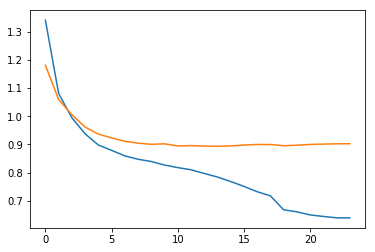

In [37]:
plt.plot(train_losses)
plt.plot(valid_losses)

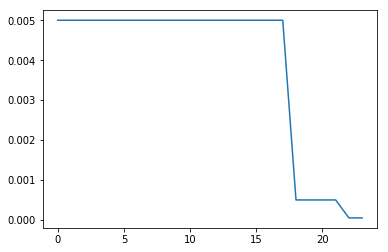

In [38]:
plt.plot(lrs)

In [41]:
print(f'Best validation loss: {best_loss}')

Best validation loss: 0.8933734191894531
